 # Projet : Prédiction du prix d'une maison

**Description :** Ce projet à pour but de mettre en pratique mes connaissances en regression lineare avec la  bibliothèque sklearn sur le modele "LinearRegression".\
Je vais donc réalisé ce projet en quelques étapes avec des explications


**IMPORT DES BUBLIOTHEQUE NECESSAIRES**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns

**IMPORT DES DONNÉES**

In [2]:
data = pd.read_csv('data/AmesHousing.txt',delimiter="\t")
#data.info()
#Je constate que mon dataSet est constiué de 2930 lignes et 82 colonnes et les types de colonnes sont des
#entier, float et d'autre sont des objets

## SELCTION DES CARACTERISTIQUES
Dans cette partie de je vais cherché les caracteristiques qui affectent le plus le prix de vente final d'une maison

Mais avant tout il faut que je me debarasse de toutes les caracteristiques qui ne pourrons pas m'aider à avoir une bonne prediction commme :

* PID
* Year Built
* Year Remod/Add
* Garage Yr Blt
* Mo Sold
* Yr Sold

In [3]:
#je vais diviser les données en deux partie bien que cette méthode risque d'avoir le biai
train = data[:1460]
test = data[1460:]

In [4]:
#Suppression des colonnes non interssantes
train = train.drop(['PID','Year Built','Year Remod/Add','Garage Yr Blt','Mo Sold','Yr Sold'],axis=1)

In [5]:
#J'avais constater que certainnes colonnes etaient de type objet
#Je vais recuperé toutes les colonnes de types entier et float  comme ça toutes les colonnes seront de type  numerique
#car les colonnes de types non numerique ne sont pas faites pour la regression lineare
train = train.select_dtypes(include=['int64','float'])

In [6]:
#La question que je pause, est ce qu'il existe de valeur manquante dans mon train
#Donc je vais recuperé les colonnes qui n'ont pas valeur manquates m
serise_cols = train.isnull().sum()
full_col_best = serise_cols[serise_cols == 0]

In [7]:
#a partir de ce data serise je peu avoir les colonnes numeriques et sans valeur manquante dans mon train et test
train = train[full_col_best.index]
train.isnull().sum()

Order              0
MS SubClass        0
Lot Area           0
Overall Qual       0
Overall Cond       0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Full Bath          0
Half Bath          0
Bedroom AbvGr      0
Kitchen AbvGr      0
TotRms AbvGrd      0
Fireplaces         0
Garage Cars        0
Garage Area        0
Wood Deck SF       0
Open Porch SF      0
Enclosed Porch     0
3Ssn Porch         0
Screen Porch       0
Pool Area          0
Misc Val           0
SalePrice          0
dtype: int64

Donc à ce stade mon train ne contient que des colonnes numerique et sans valeur manquantes.\
Et je peut donc utiliser mon objet serise "full_col_best" pour avoir les même caracteristique dans mon test 

## Corrélation des colonnes caracteristiques avec la colonne cible

Il est question maintenant de savoir quelles sont les colonnes qui ont une forte corrélation avec ma la colonnes cible. Il est possible le voir graphiquement qu'elle colonne match bien avec la colonne cible. 

In [8]:
#Je vais donc utilser une technique est consiste à calculer la matrice de corrélation.
matrice_corr = train.corr()
matrice_corr_sort =matrice_corr['SalePrice'].abs().sort_values()
matrice_corr_sort

Misc Val           0.009903
3Ssn Porch         0.038699
Low Qual Fin SF    0.060352
Order              0.068181
MS SubClass        0.088504
Overall Cond       0.099395
Screen Porch       0.100121
Bedroom AbvGr      0.106941
Kitchen AbvGr      0.130843
Pool Area          0.145474
Enclosed Porch     0.165873
2nd Flr SF         0.202352
Half Bath          0.272870
Lot Area           0.274730
Wood Deck SF       0.319104
Open Porch SF      0.344383
TotRms AbvGrd      0.483701
Fireplaces         0.485683
Full Bath          0.518194
1st Flr SF         0.657119
Garage Area        0.662397
Garage Cars        0.663485
Gr Liv Area        0.698990
Overall Qual       0.804562
SalePrice          1.000000
Name: SalePrice, dtype: float64

NB : Plus la corrélation est proche de 1 plus la colonnes est bonnes à considérées.\
Je constate donc que la colonnes "Overall Qual" est la colonne qui a une forte corrélation avec la colonne cible plus que toutes les autres.

In [9]:
#A ce stade je vais definir une valeur de seul pour choisir les colonnes
seuil = 0.3
matrice_corr_sort = matrice_corr_sort[matrice_corr_sort > 0.3]
matrice_corr_sort

Wood Deck SF     0.319104
Open Porch SF    0.344383
TotRms AbvGrd    0.483701
Fireplaces       0.485683
Full Bath        0.518194
1st Flr SF       0.657119
Garage Area      0.662397
Garage Cars      0.663485
Gr Liv Area      0.698990
Overall Qual     0.804562
SalePrice        1.000000
Name: SalePrice, dtype: float64

<AxesSubplot:>

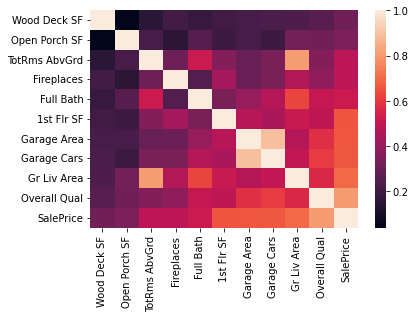

In [10]:
#Pour aller plus loin, je vais afficher la corrélation avec un hitmat de la bubliothèque seaborn
cormat = train[matrice_corr_sort.index].corr()
sns.heatmap(cormat)

Je constate qu'il y a des colonnes qui donne les même informations comme:
* "Gr Liv Area" et "TotRms AbvGrd"
* "Garage Cars" et " Garage Area "

Donc je peux me debaraser encore de caracteristiques (variables)

In [11]:
#Je decide donc de me debarasser de la variable "TotRms AbvGrd" et "Garage Cars"
final_cols = matrice_corr_sort.drop(['TotRms AbvGrd','Garage Cars']).index

In [12]:
#Mon data train et test contient à ce stade des colonne interssante et sans des valeurs manquantes
train = train[final_cols]
train = train.dropna()
test = test[final_cols]
test = test.dropna()

## Mise en place d'une fonction qui calcul entraine le modele renvoire l'erreur rmse
Cette fonction va me permettre d'évaluer different modele avec des caracteristiques differents

In [13]:
def evaluate_modele(train,test,features,targe):
    #instanciation du modele
    model = LinearRegression()
    
    #entrainement du modele
    model.fit(train[features],train[target])
    
    #predition sur des données d'entrainement et sur les données de teste
    predict_train = model.predict(train[features])
    predict_test = model.predict(test[features])
    
    #Calcul des erreurs rmse pour les données d'entrainement et de teste
    mse_train = mean_squared_error(predict_train,train[target])
    mse_test = mean_squared_error(predict_test,test[target])
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    return rmse_train, rmse_test

## Evaluation du modele
Je vais evaluer le modele avec la première meilleur variable, puis les deux première varialbes et toutes les autre qui sont superieur à mon seuil de 0.3 pour voir le changement des erreurs

In [14]:
#Avec la première meilleur variable
features = ['Overall Qual']
target = "SalePrice"
rmse_train,rmse_test = evaluate_modele(train,test,features,target)
print(rmse_train)
print(rmse_test)

46532.75573479452
49506.07186675043


In [15]:
#Avec les deux première meilleurs variables
features = ['Overall Qual','Gr Liv Area']
target = "SalePrice"
rmse_train,rmse_test = evaluate_modele(train,test,features,target)
print(rmse_train)
print(rmse_test)

40261.45272225418
42459.968118732235


In [16]:
#Avec toutes autres variables sauf SalePrice
features = final_cols.drop(['SalePrice'])
target = "SalePrice"
rmse_train,rmse_test = evaluate_modele(train,test,features,target)
print("RMSE Train : ",rmse_train)
print("RMSE Test : ",rmse_test)

RMSE Train :  34173.97629185851
RMSE Test :  41032.026120197705


Note : Je remarque que l'orsque l'erreurs rmse diminues avec deux variables, ce qui est mieux déjà\
Donc l'erreur diminue au fure et à mesure que j'augmente le nombre de caracteristiques.

**L'augementation des caracteristiques n'augmente ne diminue pas forcement les erreur du modele**

A ce state je me pause la question qui est de savoir s'il existe des colonnes à faible variance?

## Supprimer des colonnes à faible variance

Lorsque les valeurs d'une caracteristique présente une faible variance, elle ne contribut d'une manière significatie à la capacité de prédiction du modèle .
* Par exemple une colonne avec une variance 0 signifie une toutes les valeurs de cette colonne sont exatement les mêmes. Donc cela veut dire que la colonne n'apporte d'information donc il ne nous permet d'améliorer le modèle.

In [19]:
#Je vais donc redimenssionner les colonnes
unit_train = (train[features]-train[features].min() )/ (train[features].max() - train[features].min())
print(unit_train.min())
print(unit_train.max())

unit_train_sorted = unit_train.var().sort_values()
print(unit_train_sorted)

Wood Deck SF     0.0
Open Porch SF    0.0
Fireplaces       0.0
Full Bath        0.0
1st Flr SF       0.0
Garage Area      0.0
Gr Liv Area      0.0
Overall Qual     0.0
dtype: float64
Wood Deck SF     1.0
Open Porch SF    1.0
Fireplaces       1.0
Full Bath        1.0
1st Flr SF       1.0
Garage Area      1.0
Gr Liv Area      1.0
Overall Qual     1.0
dtype: float64
Open Porch SF    0.013938
Full Bath        0.018621
Garage Area      0.020347
Gr Liv Area      0.023078
Overall Qual     0.024496
1st Flr SF       0.025814
Wood Deck SF     0.033064
Fireplaces       0.046589
dtype: float64


In [20]:
#La valeur minimum de chaque colonne est bien 0 et la valeur max et bien 1
#Ensuite, j'ai les colonnes triées par ordre de croisssance de variance. Je peut donc définir un seul pour mon 
# des colonnes en fonction de la valeur de la variance
#Je fixe ma variance seuil à 0.015
#L'unique colonne à supprimer est la colonne "Open Porch SF"

In [24]:
#Avec toutes autres variables sauf SalePrice
features = final_cols.drop(['SalePrice'])
features = features.drop(["Open Porch SF"])
target = "SalePrice"
rmse_train,rmse_test = evaluate_modele(train,test,features,target)
print("RMSE Train : ",rmse_train)
print("RMSE Test : ",rmse_test)

RMSE Train :  34372.696707783965
RMSE Test :  40591.427024377204


**Je remarque une faible diminition de mes erreurs ,donc je confirme que la colonnes "Open Porch SF" n'améliorait pas 
la capacité de prédiction.**